In [1]:
import numpy      as    np
import h5py       as    h5
import ismrmrd    as    mrd
import ismrmrd.xsd
from   matplotlib import   pyplot as plt
# import seaborn    as    sns

In [2]:
def returnHeaderAndData (h5RawFilePath, dataElement='/dataset'):

   '''
      Given an ISMRMRD data file, return a tuple with the first
      element being the XML header serialized into a structure,
      and the 2nd element a Numpy array with the indices ordered
      according to the following shape:

      [coil, readout, phase_encode_1, phase_encode_2 or slice, time or contrast]
   '''

   rawDataArray = mrd.Dataset(h5RawFilePath, dataElement, True)
   rawDataArrayHeader = ismrmrd.xsd.CreateFromDocument(rawDataArray.read_xml_header())

   enc = rawDataArrayHeader.encoding[0]

   # Matrix size
   eNx = enc.encodedSpace.matrixSize.x
   eNy = enc.encodedSpace.matrixSize.y
   # eNz = enc.encodedSpace.matrixSize.z

   if enc.encodingLimits.slice != None:
      eNz = enc.encodingLimits.slice.maximum + 1
   else:
      eNz = 1

   if enc.encodingLimits.repetition != None:
      eNt = enc.encodingLimits.repetition.maximum + 1
   else:
      eNt = 1

   # This will pack k-space data into a numpy array with the following
   # data order / shape:
   #
   #    [coil, readout, phase_encode_1, phase_encode_2 or slice, time]
   #
   # This ordering may not be suitable for all, or even a majority of
   # applications.  But since this is a demonstration notebook, it
   # seemed to be a 'natural' way to unpack and organize the data from
   # the ISMRMRD raw file.

   allKspace = np.zeros((rawDataArray.read_acquisition(0).data.shape[0],
                         rawDataArray.read_acquisition(0).data.shape[1],
                         eNy, eNz, eNt), dtype=np.complex64)

   for i in range(rawDataArray.number_of_acquisitions()):
      thisAcq = rawDataArray.read_acquisition(i)
      allKspace[:, :, thisAcq.idx.kspace_encode_step_1, thisAcq.idx.slice, thisAcq.idx.contrast] = thisAcq.data

   return rawDataArrayHeader, allKspace


In [3]:
def computeAndPlot (arraySent2Plot, quant='magnitude', coil=-1):

   # print ("shape of sent array is: ", arraySent2Plot.shape)

   if (coil == -1):
      array2Plot = arraySent2Plot
   else:
      array2Plot = np.squeeze(arraySent2Plot[coil, :, :, :, :])

   # print ("shape of plotted array is: ", array2Plot.shape)

   # from comment above, the next to last index is
   # the slice slot, while the last index is
   #  repetition / contrast.
   slices2Plot = array2Plot.shape[-2]
   times2Plot  = array2Plot.shape[-1]

   # print ("slices:   ", slices2Plot)
   # print ("time pts: ", times2Plot)

   imageCols = int(np.ceil(np.sqrt(slices2Plot)))
   imageRows = int(np.ceil(np.sqrt(slices2Plot))) * times2Plot

   plottedFigures = plt.figure(figsize=(12,18))

   for t in range(times2Plot):
      for s in range(slices2Plot):
         subImages = plottedFigures.add_subplot(imageRows, imageCols, ((t * imageRows * imageCols / times2Plot) + s + 1))

         if ((quant == 'angle') or (quant == 'phase')):
            if (coil == -1):
               reconnedImage = np.sum(np.angle(array2Plot[:, :, :, s, t]), axis=0)
            else:
               reconnedImage = (np.angle(array2Plot[:, :, s, t]))
         else:
            if (coil == -1):
               reconnedImage = np.sqrt(np.sum((abs(array2Plot[:, :, :, s, t])), axis=0))
            else:
               reconnedImage = np.sqrt(((abs(array2Plot[:, :, s, t]))))

         # subImages.imshow(reconnedImage, cmap='gray')
         subImages.imshow(reconnedImage, cmap='seismic')


## First - read in (fully sampled) calibration data from array coil

In [4]:
# Put data reads from disk in their own cells as these don't need to be repeated
calDataArrayHeader, calDataArray = returnHeaderAndData('./ScanArchive_20190529_090502374_converted.h5')

In [5]:
calDataArrayImageSpace = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(calDataArray, axes=(1,2)), axes=(1,2)), axes=(1,2))
# computeAndPlot(calDataArrayImageSpace, quant='phase', coil=6)

## Now - read in data from body coil.

In [6]:
calDataBodyHeader, calDataBody = returnHeaderAndData('./ScanArchive_20190529_090622648_converted.h5')

In [7]:
# imageSpace = np.fft.fftshift(np.fft.fft2(calDataBody, axes=(1,2)), axes=(1,2))
calDataBodyImageSpace = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(calDataBody, axes=(1,2)), axes=(1,2)), axes=(1,2))
# computeAndPlot(calDataBodyImageSpace, quant='phase')

## Read in noise data from array coil.

In [8]:
noiseDataArrayHeader, noiseDataArray = returnHeaderAndData('./ScanArchive_20190529_090902358_converted.h5')

### Create an artificially sub-sampled (accelerated) set of data from the array coil data (R = 2)

In [9]:
subSampledKSpace = np.zeros((calDataArray.shape), dtype=np.complex64)
subSampledKSpace[:, :, ::2, :, :] = calDataArray[:, :, ::2, :, :]
aliasedImageSpace = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(subSampledKSpace, axes=(1,2)), axes=(1,2)), axes=(1,2))
# computeAndPlot(aliasedImageSpace, quant='mag', coil=-1)

In [10]:
scaledCalDataArray = np.divide (calDataArrayImageSpace, abs(calDataBodyImageSpace))

In [11]:
# computeAndPlot(scaledCalDataArray, quant='mag', coil=0)

In [12]:
def regularizeSensitivityMap (scaledArrayData):

   '''
      This routine should take fully sampled array coil data, already
      scaled with either its own square root of sum of squares of the
      individual coil images, or body coil data.

      The approach below computes a cosine window over the supported
      k-space region, converts the image data back into k-space data,
      applies the cosine weighting, converts back into image space,
      and is then returned.
   '''

   # First, compute cosine kernel over k-space
   smoothingKernelData = np.zeros(scaledArrayData.shape, dtype=np.float64)
   smoothingKernelData.shape

   resX = smoothingKernelData.shape[1]
   resY = smoothingKernelData.shape[2]

   midX = resX/2
   midY = resY/2

   if (resX > resY):
      maxRadius = resY / 2.0
   else:
      maxRadius = resX / 2.0

   for y in range(0, resY):
      for x in range (0, resX):
         offX = np.double(x) - np.double (midX)
         offY = np.double(y) - np.double (midY)

         radius = np.sqrt ((offX * offX) + (offY * offY))

         if (radius < maxRadius):
            smoothingKernelData[:, x, y, :, :] = np.cos(np.pi * 0.5 * radius/maxRadius)
         else:
            smoothingKernelData[:, x, y, :, :] = 0.0

   # computeAndPlot(smoothingKernelData)

   # Convert image space sensitivity map to k-space, and apply the above
   # computed (here - cosine) window
   windowedKSpace = (np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(scaledArrayData, axes=(1,2)), axes=(1,2)), axes=(1,2)) * smoothingKernelData)

   # fft back to image space and return smoothed map
   return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(windowedKSpace, axes=(1,2)), axes=(1,2)), axes=(1,2))


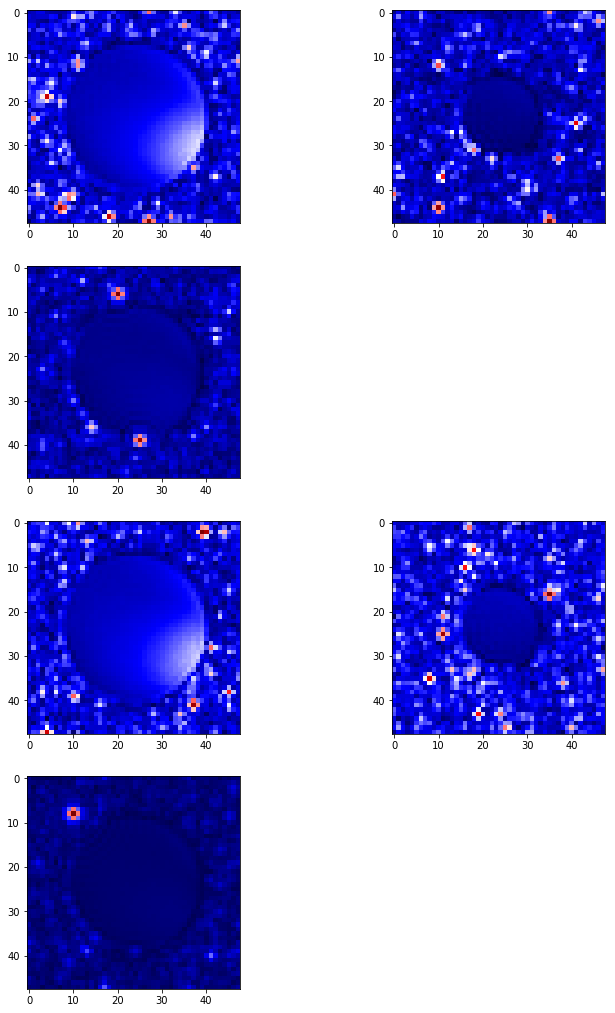

In [13]:
windowedCalDataArrayImageSpace = regularizeSensitivityMap(scaledCalDataArray)
computeAndPlot(windowedCalDataArrayImageSpace, coil=31)